# Introducción al Aprendizaje Supervisado - Clasificación (Parte II)

* Pre-procesamiento de los datos.
* Evaluación de un clasificador.
* FPR vs FNR tradeoff.

5to año - Ingeniería en Sistemas de Información

Facultad Regional Villa María

## Pre-procesamiento de datos

Un problema muy frecuente (en industria es uno de los problemas más reportados en ML) es que los datasets "crudos" no pueden recibir entrenamiento tal como están, por lo que necesitan un pre-procesamiento para poder adaptarse a los requerimientos del modelo. Vemos algunos métodos de pre-procesamiento comunes:



### Eliminación de features que no aportan a la predicción

Un problema común en los datasets es que muchas veces los mismos tienen algunas variables que no están relacionadas de ninguna forma con las salidas o bien es sabido a priori que no aportan información significativa para predecir la salida.

* Un ejemplo común son los identificadores, los cuales asocian cada fila de datos con un único código de identificación.

* Estos features deben eliminarse, porque de lo contrario el modelo los ajustará e intentará hacer predicciones con datos que no tienen aporte alguno, empeorando la calidad general del modelo.

### Ampliación o transformación del dataset

De forma similar, existen maneras de agregar o transformar datos en el dataset para mejorar las predicciones, por ejemplo incorporando información de datasets públicos o generando nuevos features a partir de los existentes o con la ayuda de información de dominio.

* Este tipo de mejoras puede ayudar a mejorar las predicciones del dataset, por ejemplo al poder utilizar features más relevantes para predecir las salidas.

* Al igual que al eliminar los features (más allá de aquellos obvios como los identificadores), no hay una regla general para ampliar el dataset, pues depende mucho del dominio del problema. Vamos a ver un ejemplo práctico de esto en la clase donde se presenta la Minería de Texto.

### Dummy variables para datasets con features no numéricos

* Por ejemplo, si tenemos que hacer una predicción y tenemos una variable categórica como por ejemplo "Género" que toma valores "Mujer" y "Varón", tal variable no puede ser utilizada de esa forma para hacer la predicción, puesto que los modelos emplean features numéricos.
* Una solución rápida consistiría en reemplazar los features asignando, por ejemplo, 0 cuando se trata de "Mujer" y 1 cuando se trata de "Varón", es decir

|        | Género |
|--------|:------:|
| Ana    |    0   |
| José   |    1   |


* El problema de este enfoque es que asumimos arbitrariamente un orden en los features, por lo cual nuestro modelo estaría innecesariamente sesgado en su entrenamiento.
* El enfoque utilizado para estos casos consiste en crear un nuevo feature para cada valor categórico posible, asignando un 1 cuando el valor pertenece a la mencionada categoría y un 0 para todas las demás categorías.
* Las variables de esta forma reciben el nombre de "dummy variable".

|        | Mujer | Varón |
|--------|:-----:|:-----:|
| Ana    |   1   |   0   |
| José   |   0   |   1   |

### Normalización de los datos

En virtud de que todos los features **contribuyan de forma equitativa** (es decir que no tengan más peso en la clasificación aquellos features con mayor magnitud), para algunos modelos se requiere que los datos estén normalizados de alguna forma, por ejemplo para que todos los valores caigan en el mismo rango fijo. La normalización se hace en cada feature. Informalmente, "para cada columna".


* Una normalización posible es **minmax normalization**, la cual transforma un feature de tal forma que todos sus valores caigan en el rango $[0,1]$.
* Para lograr esto es suficiente hacer, para cada elemento $j$ del feature $X_i$

$$Z_{ij} = \frac{X_{ij} - min(X_{i})}{max(X_{i}) - min(X_{i})}$$



Ejemplo: dados los siguientes datos,

| Feature_1 |
|:---------:|
| 42        |
| 66        |
| 187       |
| 29        |

Normalizando...

| Feature_1 |
|:---------:|
| 0.08      |
| 0.23      |
| 1         |
| 0         |

* Otra normalización muy común es la **z-score standarization**, normaliza los valores con respecto a la desviación estándar, dejando los mismos con media 0. Analíticamente, $$Z_{ij} = \frac{X_{ij} - \bar{X}}{\sigma}$$ donde $\bar{X}$ es la media de la población y $\sigma$ es la desviación estándar.

* Cada valor $Z_{ij}$ normalizado representa la distancia entre el valor $X_{ij}$ y la media de la población, en $Z_{ij}$ desviaciones estándar como unidad.

Normalizando los datos iniciales del ejemplo el ejemplo anterior...

| Feature_1 |
|:---------:|
|-0.62      |
|-0.23      |
| 1.69      |
|-0.83      |

## Evaluando un clasificador

La forma más simple de evaluar un clasificador es mediante el porcentaje de aciertos, es decir qué porcentaje de nuestras predicciones predijeron correctamente la clase de todos los puntos consultados.

* Retomamos el ejemplo de la clase pasada:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn import neighbors

iris = load_iris()
X = iris.data[:, :2]
y = iris.target

# Dividimos el conjunto en train, test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10, test_size=0.3)


clf = neighbors.KNeighborsClassifier(n_neighbors=10, weights='distance')

clf.fit(X_train, y_train)
y_hat = clf.predict(X_test)
print(y_hat)

[2 2 0 2 0 1 2 1 0 1 1 1 1 0 0 1 2 0 0 0 2 2 1 0 2 0 1 1 1 2 2 1 2 1 2 0 2
 1 2 1 0 0 1 0 2]


In [2]:
print('Porcentaje de aciertos en la clasificación: ', clf.score(X_test,y_test))

Porcentaje de aciertos en la clasificación:  0.711111111111


* Esta métrica es una buena medida para saber rápidamente la tasa de aciertos en todo clasificador. Sin embargo no nos está dando detalles como, por ejemplo, que todas las Setosas fueron correctamente clasificadas. Para ello vamos a usar mejor información, que incluya las métricas comúnmente utilizadas para evaluar un clasificador.

#### Tipos de errores

En la clasificación binaria (es decir cuando la cantidad de clases posibles a la que una variable puede pertenecer es de dos), al intentar hacer una predicción, existen dos tipos de errores de predicción a considerar.

Por ejemplo, supongamos que testeamos la existencia de una enfermedad en un paciente. Como _hipótesis nula_ $h_0$ tomamos a "$h_0$: el paciente no posee la enfermedad", mientras que como _hipótesis alternativa_ tomamos "$h_1$: el paciente posee la enfermedad".

* $h_0$ es la hipótesis que se suele usar para establecer "ausencia o inexistencia de relación entre dos fenómenos" (tomando como fenómenos el paciente y la enfermedad), mientras que $h_1$ representa "algún tipo de relación entre dos fenómenos".

* "_Inocente hasta que se demuestre lo contrario_". En testing de hipótesis, $h_0$ es la postura por defecto. Esto quiere decir que para rechazarla y por lo tanto validar una hipótesis alternativa debe demostrarse fehacientemente que $h_0$ es falsa más allá de toda duda razonable (normalmente representada por un intérvalo de confianza de 1% o 5%).

* El **error de tipo I** o **false positive** ocurre cuando se rechaza incorrectamente una $h_0$ verdadera. En nuestro ejemplo, esto sucede cuando incorrectamente diagnosticamos la enfermedad en el paciente.

* Por otra parte, el **error de tipo II** o **false negative**, ocurre cuando incorrectamente se retiene una $h_0$ falsa, siendo que se daba $h_1$. En nuestro ejemplo esto sucede cuando detectamos incorrectamente que el paciente no registra la enfermedad.

* En el caso de que la predicción haya sido correcta, decimos que la misma arrojó un **true positive** o **true negative** (_positive_ significa que existe relación entre dos fenómenos).

* En nuestro caso, true positive representa la correcta predicción en la existencia de la enfermedad mientras que false positive representa correctamente la predicción sobre la ausencia de la enfermedad.

* En nuestro ejemplo, si detectáramos varias enfermedades en el paciente y nos interesa saber $h_0$, true negative se referirá a los casos donde predecimos que el paciente no posee ninguna enfermedad y tal situación es la real; mientras que true positive se refiere a haber inferido correctamente que el paciente posee alguna enfermedad. Este enfoque se conoce como **one-vs-all**.

#### Confusion Matrix

Una forma sencilla de evaluar el rendimiento de un algoritmo es por medio de una **confusion matrix** o **error matrix**, la cual contrasta las predicciones con los valores verdaderos, mostrando los errores TI y TII.

In [3]:
from sklearn import metrics

print(metrics.confusion_matrix(y_test, y_hat, labels=[0,1,2]))


[[14  0  0]
 [ 0 10  7]
 [ 0  6  8]]


Formateando:

|                   |            |        |Clase estimada |           |
|-------------------|------------|:------:|:-------------:|:---------:|
|                   |            | Setosa |   Versicolor  | Virginica |
|                   | Setosa     | **14** |        0      |     0     |
|**Clase verdadera**| Versicolor |    0   |      **10**   |     7     |
|                   | Virginica  |    0   |        6      |   **8**   |

* En el caso de la **clasificación muticlase**, para algunos algoritmos se usa la estrategia "one-vs-all" para referirse a los tipos de errores. Es decir que cada tipo de error es calculado para cada una de las clases, tomando un label de dicha clase como positivo ($y=1$) y un label de cualquier otra clase como negativo ($y=0$). 

* Ejemplo: clasificación multiclase desde las setosas



|                   |                    |     Clase estimada      |                            |
|-------------------|--------------------|:-----------------------:|:--------------------------:|
|                   |                    | No Setosa ($\hat{y}=0$) |    Setosa ($\hat{y}=1$)    |
|                   | No Setosa ($y=0$)  |       **31**            |             0              |
|**Clase verdadera**| Setosa    ($y=1$)  |          0              |          **14**            |

* Esto se hace para poder extender el problema a partir de una clasificación binaria, pudiendo evaluar los errores TI y TII de la misma forma.

* Vemos ahora con mejor nivel de detalle aspectos como que las 14 flores Setosa utilizadas para el test fueron correctamente clasificadas, mientras que las flores Versicolor se confunden frecuentemente con las Virginica.

Vamos a procesar todavía más esta información al calcular métricas adicionales que nos permitirán obtener más claridad.


![Positives - Negatives](images/positives_negatives.png)

Fuente: Walber (usuario de Wikipedia), imagen adaptada desde https://en.wikipedia.org/wiki/Precision_and_recall

Concepto preliminar: en la clasificación binaria, es decir aquellos problemas donde $c_i \in \{False, True\}$, el **umbral** o _threshold_ $\theta \in [0,1]$ es la probabilidad mínima que hace que el predictor clasifique una observación como True. Aquellas probabilidades por debajo del umbral son clasificadas como False.

Por ejemplo, un $\theta = 0.75$ hace necesario que $P(y=1 \mid x) > 0.75$.

#### Métricas desde el punto de vista de los negativos




La primera métrica es el **false positive rate (FPR)** (o proporción de falsas alarmas), que representa el porcentaje de errores de TI en la clasificación, es decir

$$ FPR = \frac{FP}{\text{actual negatives}} = \frac{FP}{FP + TN}$$

Un predictor no tendría falsas alarmas si se clasificara todo como "False", al usar un umbral $\theta=1$.

Por otra parte, el **false negative rate (FNR)** (o proporción de detecciones perdidas) representa el porcentaje de errores TII en la clasificación, es decir

$$ FNR = \frac{FN}{\text{actual positives}} = \frac{FN}{FN + TP}$$

Un predictor no tendría detecciones perdidas si clasificara todo como "True", usando un umbral $\theta = 0$.

#### Métricas desde el punto de vista de los positivos

![](images/precision_recall.png)

Fuente: Walber (usuario de Wikipedia), imagen adaptada desde https://en.wikipedia.org/wiki/Precision_and_recall

Uno de los indicadores principales es el **positive predictive value** o **precision**, que representa el porcentaje de positivos correctamente inferidos como tal por cada positivo inferido. Está dado por

$$P(y=1 \mid \hat{y}=1) = \frac{TP}{\text{predicted positives}} = \frac{TP}{TP + FP}$$

Intuitivamente puede interpretarse como "qué tan seguro es un clasificador al inferir las observaciones como positivas". Un predictor maximizaría esta métrica si clasificara como "True" sólo aquellas observaciones con las que cuente con total certeza que son "True".

Otro indicador principal es el **true positive rate**, **sensitivity** o **recall**, que representa el porcentaje de positivos correctamente inferidos por cada positivo real, dado por

$$P(\hat{y}=1 \mid y=1)= \frac{TP}{\text{actual positives}} = \frac{TP}{TP + FN}$$

Intuitivamente puede interpretarse como "qué tan bueno es un clasificador en detectar los positivos". Un predictor sería perfecto en la detección de positivos si clasificara todo como "True", al usar un umbral $\theta = 0$.

Análogamente, el **true negative rate** o **specificity** es similar al recall pero considerando los negativos, es decir

$$P(\hat{y}=0 \mid y=0)= \frac{TN}{\text{actual negatives}} = \frac{TN}{TN + FP}$$

Intuitivamente puede interpretarse como "qué tan bueno es un clasificador evitando las falsas alarmas". Como vimos antes, un predictor sería perfecto en evitar falsas alarmas si clasificara todo como "False", es decir usara un $\theta=1$.

La primera medida que vimos, el porcentaje de aciertos (**accuracy**) está dada por

$$\text{accuracy} = \frac{\text{correctly predicted}}{\text{all predicted}} = \frac{TP + TN}{TP + FP + TN + FN}$$

Como es trivial y poco útil maximizar una métrica por separado, un buen clasificador debería, en general (y dependiendo del problema que trata de resolver), intentar maximizar conjuntamente tanto precision como recall. Normalmente ambos representan intereses contrapuestos.

* Considerar como ejemplo la extracción de un tumor cerebral, donde un cirujano debe intentar maximizar la cantidad de células cancerígenas extraídas (recall) para evitar que se regenere el tumor, minimizando a su vez la cantidad de células no cancerígenas extraídas (precision) que podrían afectar las funciones cerebrales.

* Debido a que ambas métricas van de la mano, para evaluarlas conjuntamente se suele usar el F1 score, dado por la media armónica

$$F_1 = \frac{2}{P^{-1}+R^{-1}}$$

Scikit-learn convenientemente hace este procesamiento por nosotros, como vemos a continuación:

In [4]:
print(metrics.classification_report(y_test, y_hat, target_names=iris.target_names))

             precision    recall  f1-score   support

     setosa       1.00      1.00      1.00        14
 versicolor       0.62      0.59      0.61        17
  virginica       0.53      0.57      0.55        14

avg / total       0.71      0.71      0.71        45



Notar que _support_ es la cantidad de instancias (true values) de cada una de las clases.

## False positive vs false negative tradeoff

Como acabamos de ver, la contraposición de intereses en un clasificador se da porque existe una relación inversa entre los errores false positive (falsa alarma) y los errores false negative (detección perdida).

* La inclinación que querramos darle a este tradeoff depende del problema que estemos intentando resolver.

* Para aquellas tareas que se desempeñan en entornos con aversión al riesgo, como vemos en el ejemplo de la cirugía cerebral, debemos diseñar nuestro clasificador de tal forma que se minimicen los costos totales producidos por los errores de predicción.

* En la clasificación binaria, una de las opciones es incluir una **reject region**, es decir un umbral de probabilidad donde el predictor, en lugar de clasificar como False, no tomará decisiones, dejando las mismas en manos de una persona, por ejemplo.

![](images/reject_region.png)

Fuente: Figura 1.26 de Bishop 2006a (nota: no confundir $\theta$ utilizado en la figura y en el notebook para denotar un umbral con $\theta$ comúnmente utilizado para referirse a los híper-parámetros del predictor)

Alternativamente, si queremos tomar esa decisión pero que nuestro clasificador sea conservador debido al posible costo de los errores, podemos usar el mismo umbral para definir hasta cuánto debe ser nuestro grado de seguridad para asegurar o rechazar $h_0$.

* En los clasificadores probabilísticos vistos aquí, el umbral es establecido al ver la probabilidad de predicción de as distintas clases, y alterando la clase elegida cuando la misma no supera el umbral.

* Por defecto, el umbral utilizado en los clasificadores binarios es $\theta=0.5$, mientras que en los clasificadores multi-clase se selecciona la clase que arroje mayor probabilidad.

* Veamos las probabilidades de nuestro predictor...

In [5]:
print(clf.predict_proba(X_test))

# cada una de las columnas de salida representa la probabilidad estimada por el clasificador para cada una de las clases. 

[[ 0.          0.49055281  0.50944719]
 [ 0.          0.27075062  0.72924938]
 [ 1.          0.          0.        ]
 [ 0.          0.          1.        ]
 [ 1.          0.          0.        ]
 [ 0.          0.82398271  0.17601729]
 [ 0.          0.43565179  0.56434821]
 [ 0.          0.5         0.5       ]
 [ 1.          0.          0.        ]
 [ 0.          1.          0.        ]
 [ 0.          1.          0.        ]
 [ 0.          0.5         0.5       ]
 [ 0.          0.92108116  0.07891884]
 [ 1.          0.          0.        ]
 [ 1.          0.          0.        ]
 [ 0.          0.57698118  0.42301882]
 [ 0.06713528  0.22517858  0.70768614]
 [ 1.          0.          0.        ]
 [ 1.          0.          0.        ]
 [ 1.          0.          0.        ]
 [ 0.          0.3238972   0.6761028 ]
 [ 0.          0.          1.        ]
 [ 0.          0.51724172  0.48275828]
 [ 1.          0.          0.        ]
 [ 0.          0.          1.        ]
 [ 1.          0.        

No obstante, en determinadas situaciones es deseable cambiar el umbral, por ejemplo...

1. Los errores FP y FN tienen una incidencia distinta en el problema para el cuál utilizamos el clasificador.
2. Deseamos testear la certeza con la que nuestro clasificador toma las decisiones.

Analizamos ambos casos:

>1. Los errores FP y FN tienen una incidencia distinta en el problema para el cuál utilizamos el clasificador.

* Dadas dos clases 0 y 1, si queremos minimizar el costo de nuestros errores, utilizamos la _loss matrix_

$$
L =\begin{pmatrix}{}
  & \hat{y}=0 & \hat{y}=1 \\
y=0 & 0 & L_{FP} \\
y=1 & L_{FN} & 0 \end{pmatrix}
$$

donde $L_{FN}$ es el costo de un error FN mientras que $L_{FP}$ es el costo de un error FP. La posterior expected loss $L$ para ambas acciones está dada por

$$L(\hat{y}=0 \mid X)=L_{FN}P(y=1 \mid X)$$
$$L(\hat{y}=1 \mid X)=L_{FP}P(y=0 \mid X)$$

Por lo tanto, deberíamos escoger la clase 1 si y solo si

$L(\hat{y}=0 \mid X) > L(\hat{y}=1 \mid X)$

Si $L_{FN} = c L_{FP}$, entonces elegiremos $\hat{y}=1$ si

$$P(y=1 \mid X) > \frac{1}{c} P(y=0 \mid X)$$

¿Qué significa esto? Significa que si un FN cuesta 2 veces lo que un FP (lo que implica un $c=2$), elegiremos $\hat{y}=1$ siempre que $P(y=1 \mid X) > \frac{1}{2} P(y=0 \mid X)$; es decir que lo elegiremos siempre que $P(y=1 \mid X) > 0.33$.

> 2\. Deseamos testear la certeza con la que nuestro clasificador toma las decisiones.

### Receiver operating characteristic (ROC) curve

* Los umbrales también pueden utilizarse para evaluar la _certeza_ de nuestro clasificador, es decir con qué margen de confianza infiere la clase de cada una de las observaciones, para de esta manera poder compararlo mejor frente a otros clasificadores en cuanto a su capacidad de generalizar.

* Por ejemplo, el clasificador A y el clasificador B pueden tener idénticas predicciones para un dataset, pero A estar clasificando a todas las clases con un 95% de probabilidad y B estar clasificando con un 51%.

* Distinguir entre ambos clasificadores es precisamente la idea de las curvas ROC. En ellas se muestra cómo se comparan los distintos clasificadores en términos de TPR y FPR con respecto a la suposición aleatoria (elige clase 0 o 1 aleatoriamente) y al clasificador perfecto, mostrando el equilibrio entre true positives y false positives para las distintas instancias.



* Veamos cómo se ve una curva ROC para nuestro ejemplo. Fuente: https://github.com/reiinakano/scikit-plot.

In [6]:
# instalamos la dependencia requerida

from IPython.display import clear_output

import pip
pip.main(["install", "scikit-plot"])
clear_output()

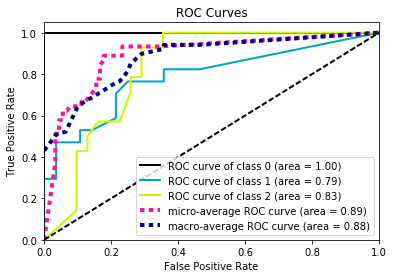

In [7]:
import scikitplot as skplt

y_hat_probas = clf.predict_proba(X_test)

# predicted probabilities generated by sklearn classifier
skplt.metrics.plot_roc_curve(y_test, y_hat_probas)
plt.show()

Notar que micro-average ROC curve es el promedio de las áreas de las curvas ROC, mientras que macro-average ROC curve es el mismo promedio pero ponderado por la cantidad de observaciones de cada clase.

* Para comparar la calidad de las curvas ROC, una medida utilizada es comparar su área bajo la curva de cada clasificador.

* Notar que cualquier clasificador puede alcanzar el límite inferior izquierdo (TPR=FPR=0) al setear $\theta=1$ y por lo tanto clasificar todo como 0. Análogamente, setear $\theta=0$ hará que todos los resultados sean clasificados como 1, obteniendo (TPR=FPR=1).

* Trazar una línea (TPR=FPR) muestra cómo se desempeña el clasificador aleatorio, el cual es el piso mínimo que todo clasificador debe superar.

* Para medir la perfomance de los clasificadores de acuerdo a sus curvas ROC, el criterio utilizado es el de calcular el área bajo la curva ROC (número real que va de 0 a 1). Esta, junto con precision, recall, f1 y la tasa de aciertos, es otra métrica muy útil para evaluar el rendimiento de nuestro clasificador.

Para ver solamente la métrica del AUC de la curva ROC se puede usar esta librería (sólo para clasificación binaria):

http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score

### Trabajo Práctico 3 - Parte II

Para los siguientes ejercicios vamos a usar el Wisconsin Breast Cancer dataset, construido a partir de imágenes digitalizadas. Las mismas describen la información obtenida de cada imagen de célula mamaria biopsiada, especificando si el diagnóstico sobre la misma es que es benigna o maligna. Fuente: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic).


#### Ejercicios Básicos

1. Aplicarle normalización z-score a los datos. Dividir en conjunto de train, validación y test. Nota: para implementar esto se puede utilizar kFolds o bien hacer una sola vez la división.

2. Implementar un clasificador kNN para todos los features el dataset Wisconsin Breast Cancer (plantilla de código provista debajo). Entrenarlo y determinar su híper-parámetro k de acuerdo a la tasa de aciertos, usando el subconjunto de validación. Tras finalizar el entrenamiento, mostrar en pantalla la correspondiente tasa de aciertos, precision, recall, f1-score y área bajo la curva ROC.


#### Ejercicios Complementarios

1. Considerar el caso donde un incorrecto diagnóstico de cáncer cuando la célula es benigna tiene un costo de 7, mientras que una errónea omisión de una célula maligna tiene un costo de 18. De acuerdo a lo visto en este notebook, modificar las salidas del clasificador para que el mismo realice la mayor reducción posible del costo por errores de clasificación, e imprimir dichas salidas.

2. Considerando el punto anterior, modificar el código del ejercicio básico para que que cambie el criterio de optimización del híper-parámetro k, de modo que el mismo apunte a minimizar el costo de los errores de predicción, en lugar de maximizar la tasa de aciertos. Mostar en pantalla cuál es el costo mínimo obtenido tras dicha minimización, junto a su correspondiente k.


#### Ejercicios Extra


Fecha de entrega: **16/5/2018 23:55**.

Nota: la resolución de los ejercicios es **individual**. La reutilización del código del notebook está permitida (por ejemplo para confeccionar gráficos).

In [8]:
# Código inicial

from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()

# En el siguiente ejercicio, al no emplear gráficos, vamos a apuntar a obtener el mejor
# rendimiento posible de nuestro estimador, por lo que vamos a tomar la dimensionalidad completa del dataset,
# lo que significa que no vamos a elegir un feature en concreto como en la clase pasada sino todos los features
X = data.data
y = data.target

# Nota: tener en cuenta que, en este dataset, y==0 representa que la célula es maligna mientras que
# un y==1 representa que la célula es benigna. Se aclara esto dado que puede generar confusión
# debido a que difiere del criterio en el cual el 0 representa la ausencia de relación de dos
# fenómenos
print(data.target_names)

# TODO seguir aquí


['malignant' 'benign']


In [9]:
# Información sobre el dataset
# help(load_breast_cancer)